# COASTSAT & Wave Data

In [1]:
import matplotlib.pyplot as plt
from matplotlib import path
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats

import buoypy as bp
import data_prep_fun as dpf


## CoastSat
## Initial settings
Refer to the Installation section of the README for instructions on how to install the Python packages necessary to run the software, including Google Earth Engine Python API. If that step has been completed correctly, the following packages should be imported without any problem.



In [1]:
import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.ion()
import pandas as pd
from datetime import datetime


from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_transects

### 1. Retrieval of the images from GEE
Define the region of interest (polygon), the date range (dates) and the satellite missions (sat_list) from which you wish to retrieve the satellite images. The images will be cropped on the Google Earth Engine server and only the region of interest will be downloaded as a .tif file. The files will stored in the directory defined in filepath.

Make sure the area of your ROI is smaller than 100 km2 (if larger split it into smaller ROIs).

The function SDS_download.check_images_available(inputs) will print the number of images available for your inputs. The Landsat images are divided in Tier 1 and Tier 2, only Tier 1 images can be used for time-series analysis.

In [2]:
# region of interest (longitude, latitude)
polygon = [[[-80.181811, 42.175542],
[-80.053400,  42.175938],
[-80.055316,  42.099772],
[-80.178013,  42.100109],
[-80.181811, 42.175542]]]
 
# it's recommended to convert the polygon to the smallest rectangle (sides parallel to coordinate axes)       
polygon = SDS_tools.smallest_rectangle(polygon)
# date range
dates = ['1985-04-01', '1985-09-01']
# satellite missions
sat_list = ['L5']
# name of the site
sitename = 'Erie_test'
# directory where the data will be stored
filepath = os.path.join(os.getcwd(), 'data')
# put all the inputs into a dictionnary
inputs = {'polygon': polygon, 'dates': dates, 'sat_list': sat_list, 'sitename': sitename, 'filepath':filepath}

# before downloading the images, check how many images are available for your inputs
SDS_download.check_images_available(inputs);

Images available between 1985-04-01 and 1985-09-01:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
  L5: 6 images
  Total: 6 images
- In Landsat Tier 2:
  L5: 4 images
  Total: 4 images


The function SDS_download.retrieve_images(inputs) retrives the satellite images from Google Earth Engine.

By default, only Landsat Tier 1 Top-of-Atmosphere and Sentinel-2 Level-1C products are downloaded.

In case you need to access Tier 2 images for qualitative analysis, you need to set inputs['include_T2'] = True before calling retrieve_images.

In [3]:
# inputs['include_T2'] = True
metadata = SDS_download.retrieve_images(inputs)

Images available between 1985-04-01 and 1985-09-01:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
  L5: 6 images
  Total: 6 images
- In Landsat Tier 2:
  L5: 4 images
  Total: 4 images

L5: 6 images
100%


If you have already retrieved the images, just load the metadata file by only running the section below

In [4]:
metadata = SDS_download.get_metadata(inputs) 

## 2. Shoreline extraction
This section maps the position of the shoreline on the satellite images. The user can define the cloud threhold (cloud_thresh) and select the spatial reference system in which to output the coordinates of the mapped shorelines (output_epsg). See http://spatialreference.org/ to find the EPSG number corresponding to your local coordinate system. Make sure that your are using cartesian coordinates and not spherical coordinates (lat,lon) like WGS84. If unsure, use 3857 which is the web mercator projection (used by Google Maps).

To quality control each shoreline detection and manually validate the mapped shorelines, the user has the option to set the parameter check_detection to True. To adjust the position of each shoreline by modifying the threshold defining the sand/water interface you can set adjust_detection to True. Finally, to save a figure for each mapped shoreline as a .jpg in the folder /jpg_files/detection set save_figure to True.

The other parameters are for advanced users only and are described in the README.

In [5]:
settings = { 
    # general parameters:
    'cloud_thresh': 0.5,        # threshold on maximum cloud cover
    'output_epsg': 32617,        # epsg code of spatial reference system desired for the output   
    # quality control:
    'check_detection': True,    # if True, shows each shoreline detection to the user for validation
    'adjust_detection': False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
    'save_figure': True,        # if True, saves a figure showing the mapped shoreline for each image
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    'min_beach_area': 4500,     # minimum area (in metres^2) for an object to be labelled as a beach
    'buffer_size': 150,         # radius (in metres) for buffer around sandy pixels considered in the shoreline detection
    'min_length_sl': 200,       # minimum length (in metres) of shoreline perimeter to be valid
    'cloud_mask_issue': False,  # switch this parameter to True if sand pixels are masked (in black) on many images  
    'sand_color': 'default',    # 'default', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
    # add the inputs defined previously
    'inputs': inputs
}

### [OPTIONAL] Save .jpg of the satellite images
Saves .jpg files of the preprocessed satellite images (cloud masking + pansharpening/down-sampling) under ./data/sitename/jpeg_files\preprocessed

In [6]:
SDS_preprocess.save_jpg(metadata, settings)

Satellite images saved as .jpg in C:\Users\HP\Desktop\coastal\data\Erie_test\jpg_files\preprocessed


### [OPTIONAL] Digitize a reference shoreline
Creates a reference shoreline which helps to identify outliers and false detections. The reference shoreline is manually digitised by the user on one of the images. The parameter max_dist_ref defines the maximum distance from the reference shoreline (in metres) at which a valid detected shoreline can be. If you think that the default value of 100 m will not capture the full shoreline variability of your site, increase this value to an appropriate distance.

In [9]:
%matplotlib qt

settings['reference_shoreline'] = SDS_preprocess.get_reference_sl(metadata, settings)
#print(settings['reference_shoreline'])
np.savetxt('pt_coords.txt',settings['reference_shoreline'])

#settings['max_dist_ref'] = 1000 # max distance (in meters) allowed from the reference shoreline

[]
Reference shoreline has been saved in C:\Users\HP\Desktop\coastal\data\Erie_test


## Extract Wave Data

This section will extract wave data from an NDBC buoy and prepare it for input into the CEM. The user must provide the buoy identifier. 

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import buoypy as bp

In [17]:
# user input from NDBC buoy (make sure buoy has wave height available)
station = 45167
year = np.NAN
year_range = (2014,2020)

H = bp.historic_data(station,year,year_range)
X = H.get_all_stand_meteo()

Appending data from: http://www.ndbc.noaa.gov/view_text_file.php?filename=45167h2014.txt.gz&dir=data/historical/stdmet/
Appending data from: http://www.ndbc.noaa.gov/view_text_file.php?filename=45167h2015.txt.gz&dir=data/historical/stdmet/
Appending data from: http://www.ndbc.noaa.gov/view_text_file.php?filename=45167h2016.txt.gz&dir=data/historical/stdmet/
Appending data from: http://www.ndbc.noaa.gov/view_text_file.php?filename=45167h2017.txt.gz&dir=data/historical/stdmet/
Appending data from: http://www.ndbc.noaa.gov/view_text_file.php?filename=45167h2018.txt.gz&dir=data/historical/stdmet/
Appending data from: http://www.ndbc.noaa.gov/view_text_file.php?filename=45167h2019.txt.gz&dir=data/historical/stdmet/
Appending data from: http://www.ndbc.noaa.gov/view_text_file.php?filename=45167h2020.txt.gz&dir=data/historical/stdmet/


In [18]:
# get rid of missing data
X.mask((X==99.0) | (X==9999.0), inplace=True)
#X.head(3) #preview first 3 lines of table

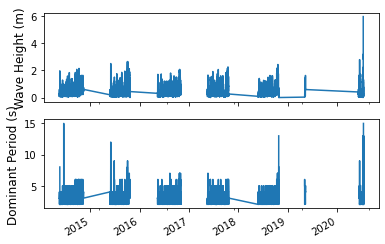

In [9]:
# plot relevant data to check it looks ok
plotdata = True
if plotdata == True: dpf.plotmeteo(X)


In [19]:
# prep wave data for CEM
Hs = np.mean(X.WVHT)
Tp = np.mean(X.DPD)
[Dir,count] = stats.mode(X.WDIR) # is this how we want to do this for dir? find peak instea?

print(Hs, Tp, Dir)

0.4855724949016968 3.1576545790785557 [214.]


## Convert CoastSat shoreline to grid for CEM

In [6]:
# dummy shoreline that will be replaced by CoastSat shoreline
xy = np.loadtxt('Erie_spit_ESPIn.xy')
# shoreline
x=xy[:,0]
y=xy[:,1]
dx=100
dy=100

CoastSat outputs an array of [X,Y] UTM coordinates for our shoreline. CEM requires an [X,Y,Z] mesh. In the shorelinetogrid function we generate crossshore elevation for our grid using the Dean Profile equation (Dean, 1991): 

$h(x) = Ax^{m}$

where:
    <li>h=depth (m)</li>
    <li>x=cross-shore distance (m)</li> 
    <li>A=shape parameter (0.05 to 0.25 based on sed. characteristics, hardcoded to be 0.1)</li>
    <li>m = 2/3 (describes the typical concave up shape of beach slope</li>
       
*note that while this equation can provide a relatively accurate first cut assesment of nearshore bathymetry, it was designed for planar beaches with uniform slope (i.e., no sand bars or complicated bathymetry)*

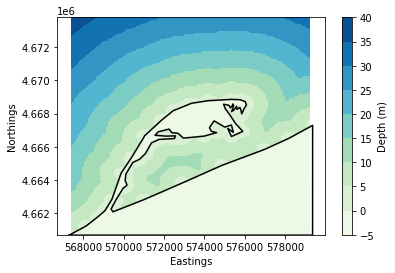

In [7]:
[xg,yg,elev] = dpf.shorelinetogrid(x,y,dx,dy,plotdata=True)